In [173]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
import dash
from dash import dcc, html
import plotly.express as px
import os

# **Data Cleaning and Preprocessing**

In [174]:
df_new = pd.read_csv('D:\DataScience Project Final\Datatset\predictive_maintenance.csv')
print(df_new.head())

   UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   
3    4     L47183    L                298.2                    308.6   
4    5     L47184    L                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Target Failure Type  
0                    1551         42.8                0       0   No Failure  
1                    1408         46.3                3       0   No Failure  
2                    1498         49.4                5       0   No Failure  
3                    1433         39.5                7       0   No Failure  
4                    1408         40.0                9       0   No Failure  


<>:1: SyntaxWarning:

invalid escape sequence '\D'

<>:1: SyntaxWarning:

invalid escape sequence '\D'

C:\Users\mnand\AppData\Local\Temp\ipykernel_11512\1156737240.py:1: SyntaxWarning:

invalid escape sequence '\D'



In [175]:
missing_values = df_new.isnull().sum()

In [176]:
if missing_values.sum() > 0:
    print("Missing values detected. Filling missing values...")
    
    # Fill missing values for numeric columns with the mean
    for col in df_new.select_dtypes(include=['number']).columns:
        df_new[col].fillna(df_new[col].mean(), inplace=True)
    
    # Fill missing values for non-numeric columns with the most frequent value (mode)
    for col in df_new.select_dtypes(exclude=['number']).columns:
        if not df_new[col].mode().empty:
            df_new[col].fillna(df_new[col].mode()[0], inplace=True)
        else:
            # If mode is empty (all values are NaN), replace with a placeholder
            df_new[col].fillna("Unknown", inplace=True)
    
    print("Missing values handled successfully.")
else:
    print("No missing values detected.")

No missing values detected.


In [177]:
# Check for duplicates
duplicates = df_new.duplicated()

In [178]:
if duplicates.sum() > 0:
    print(f"{duplicates.sum()} duplicate rows detected. Removing duplicates...")
    df_new.drop_duplicates(inplace=True)
    print("Duplicates removed successfully.")
else:
    print("No duplicate rows detected.")

No duplicate rows detected.


In [179]:
# - Creating Temperature Difference
df_new['temp_diff'] = df_new['Process temperature [K]'] - df_new['Air temperature [K]']

In [180]:
# - Creating Interaction features (e.g., torque-speed interaction)
df_new['torque_speed_interaction'] = df_new['Torque [Nm]'] * df_new['Rotational speed [rpm]']

In [181]:
# Selecting columns to be normalized
sensor_columns = ['Air temperature [K]', 'Process temperature [K]','Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'temp_diff', 'torque_speed_interaction']

In [182]:
# Initializing the scaler
scaler = StandardScaler()

In [183]:
# Applying standardization
df_new[sensor_columns] = scaler.fit_transform(df_new[sensor_columns])

In [184]:
# Checking the results
print(df_new.head())

   UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M            -0.952389                -0.947360   
1    2     L47181    L            -0.902393                -0.879959   
2    3     L47182    L            -0.952389                -1.014761   
3    4     L47183    L            -0.902393                -0.947360   
4    5     L47184    L            -0.902393                -0.879959   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Target Failure Type  \
0                0.068185     0.282200        -1.695984       0   No Failure   
1               -0.729472     0.633308        -1.648852       0   No Failure   
2               -0.227450     0.944290        -1.617430       0   No Failure   
3               -0.590021    -0.048845        -1.586009       0   No Failure   
4               -0.729472     0.001313        -1.554588       0   No Failure   

   temp_diff  torque_speed_interaction  
0   0.498849                  0.629443  
1   

# ***Exploratory Data Analysis (EDA)***

Tool Wear and Failure Probability

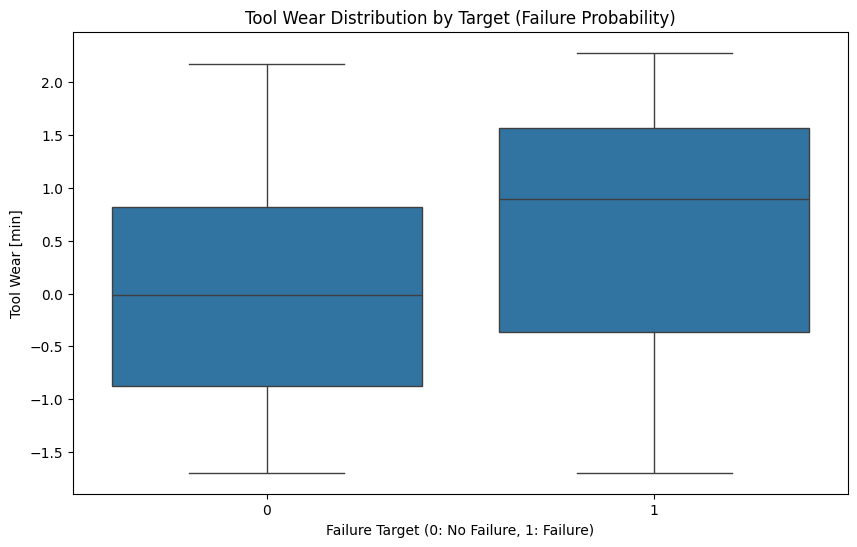

Tool Wear Summary Statistics for Failures:
 count    339.000000
mean       0.562925
std        1.143107
min       -1.695984
25%       -0.368431
50%        0.896279
75%        1.563983
max        2.278819
Name: Tool wear [min], dtype: float64

Tool Wear Summary Statistics for Non-Failures:
 count    9661.000000
mean       -0.019753
std         0.988921
min        -1.695984
25%        -0.879028
50%        -0.014941
75%         0.817725
max         2.168844
Name: Tool wear [min], dtype: float64


In [185]:
# Check distribution of tool wear for different failure targets
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_new, x='Target', y='Tool wear [min]')
plt.title('Tool Wear Distribution by Target (Failure Probability)')
plt.xlabel('Failure Target (0: No Failure, 1: Failure)')
plt.ylabel('Tool Wear [min]')
plt.show()

# Calculate descriptive statistics of Tool Wear for failed vs. non-failed cases
failed_tool_wear = df_new[df_new['Target'] == 1]['Tool wear [min]']
non_failed_tool_wear = df_new[df_new['Target'] == 0]['Tool wear [min]']

# Summary statistics
failed_summary = failed_tool_wear.describe()
non_failed_summary = non_failed_tool_wear.describe()

# Displaying summary statistics
print("Tool Wear Summary Statistics for Failures:\n", failed_summary)
print("\nTool Wear Summary Statistics for Non-Failures:\n", non_failed_summary)


Distribution of Features

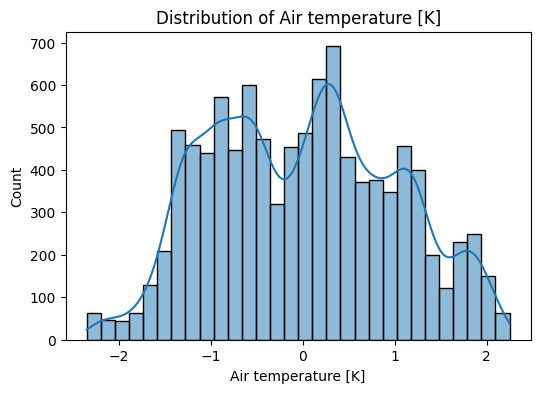

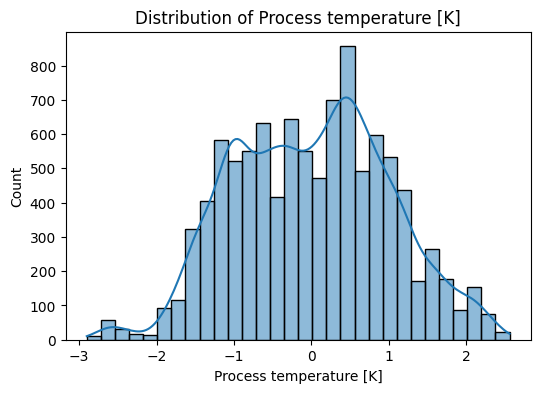

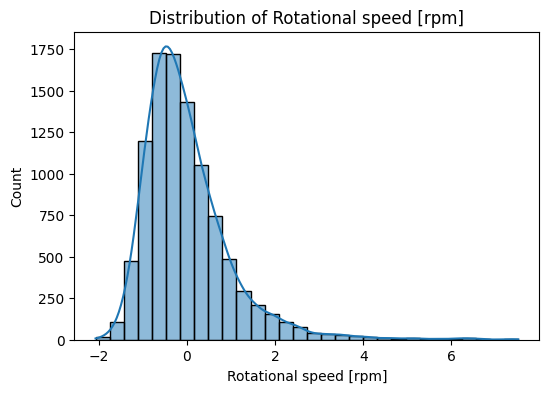

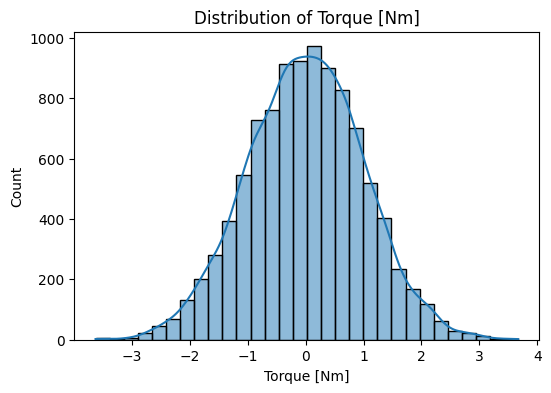

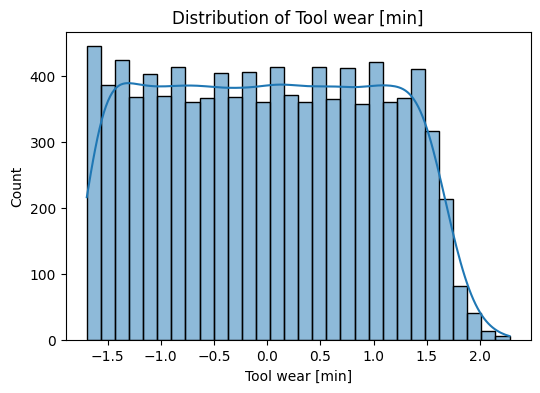

In [186]:
# Plotting the distribution of numerical features
numerical_features = ['Air temperature [K]', 'Process temperature [K]',
                      'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']

# Plot histograms for all numerical features
for feature in numerical_features:
    plt.figure(figsize=(6, 4))
    sns.histplot(df_new[feature], bins=30, kde=True)
    plt.title(f'Distribution of {feature}')
    plt.show()


Failure Types Distribution

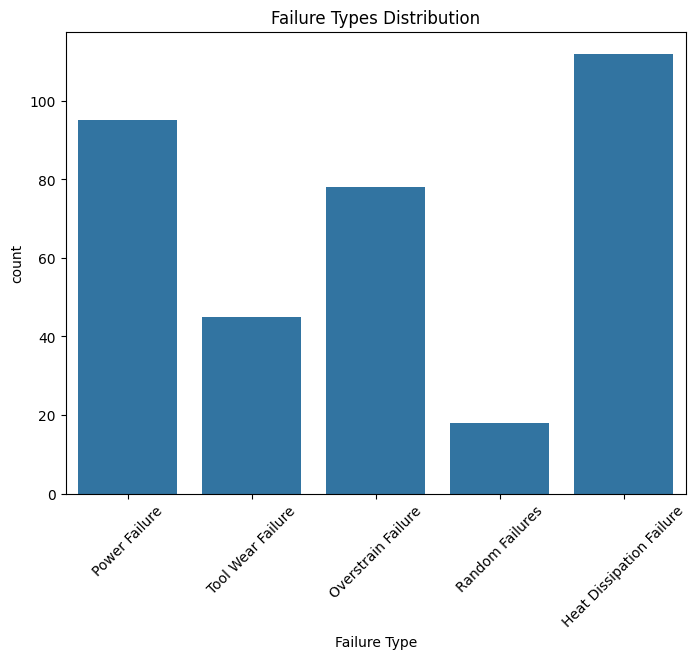

In [187]:
# Filter out 'No Failure' from the dataset
failure_data = df_new[df_new['Failure Type'] != 'No Failure']

# Plot the count of each failure type excluding 'No Failure'
plt.figure(figsize=(8, 6))
sns.countplot(x='Failure Type', data=failure_data)
plt.title("Failure Types Distribution")
plt.xticks(rotation=45)
plt.show()


Correlation Matrix

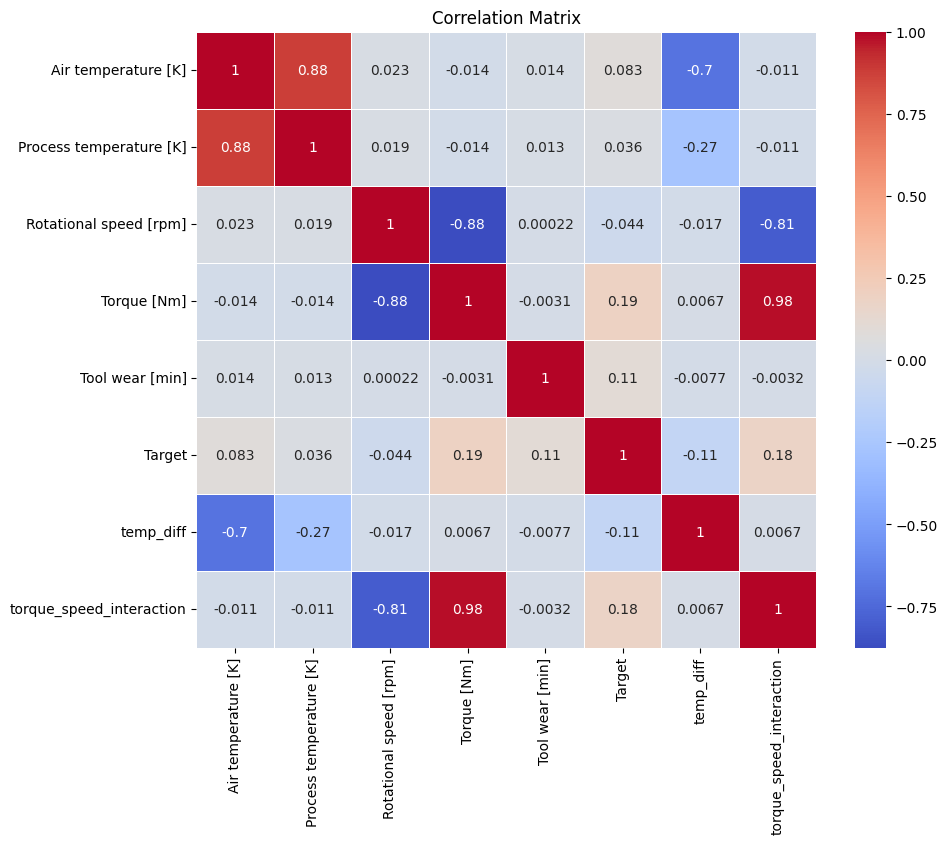

In [188]:
# Compute the correlation matrix
corr_matrix = df_new.drop(columns=['UDI']).select_dtypes(include=np.number).corr()

# Plot the heatmap of correlations
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()


Feature vs. Target Analysis

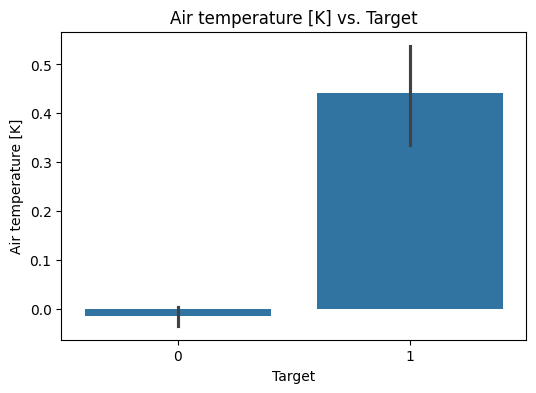

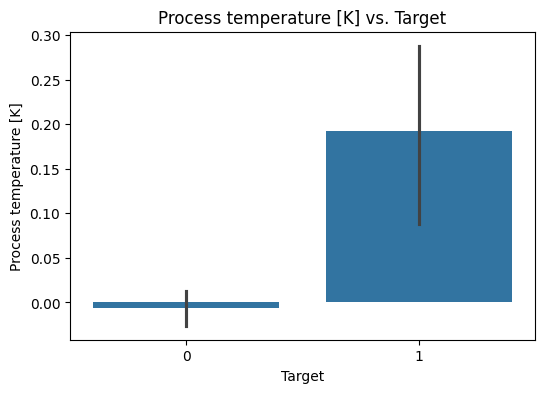

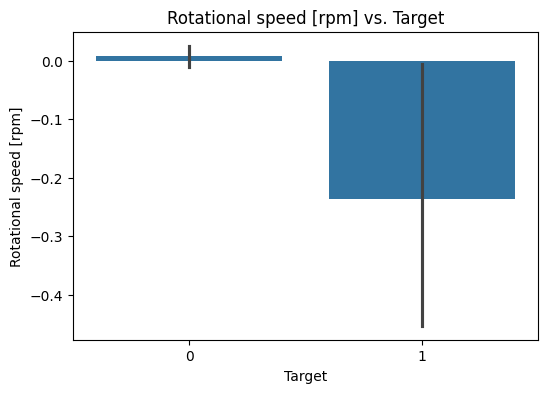

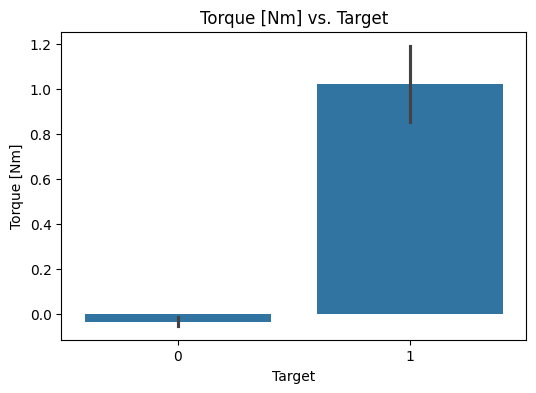

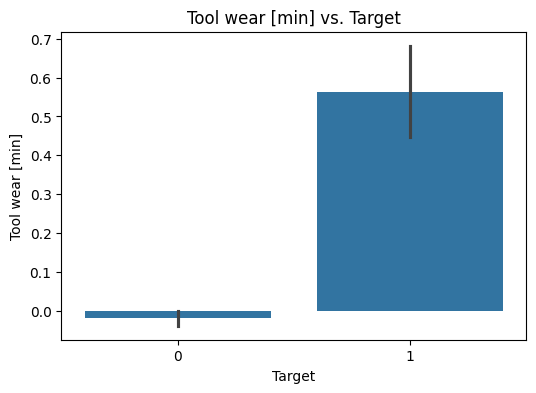

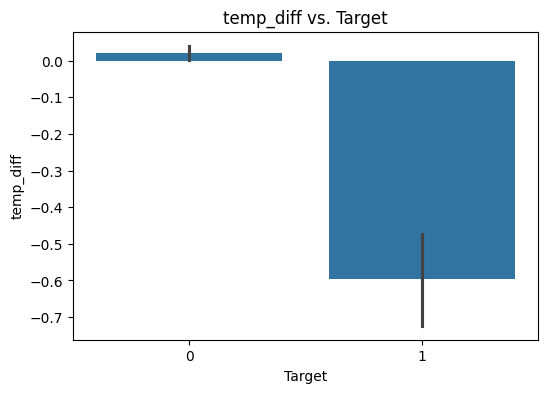

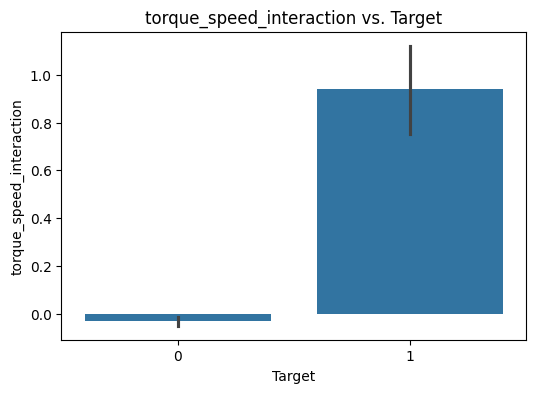

In [189]:
# Remove 'Target' and 'UDI' from the list of numerical features
numerical_features = df_new.select_dtypes(include=np.number).columns.tolist()
if 'UDI' in numerical_features:
    numerical_features.remove('UDI')
if 'Target' in numerical_features:
    numerical_features.remove('Target')
if 'Time' in numerical_features:
    numerical_features.remove('Time')

# Plot the barplots for each remaining numerical feature vs. Target
for feature in numerical_features:
    plt.figure(figsize=(6, 4))
    sns.barplot(x='Target', y=feature, data=df_new)
    plt.title(f'{feature} vs. Target')
    plt.show()


Failure Type vs. Product Type

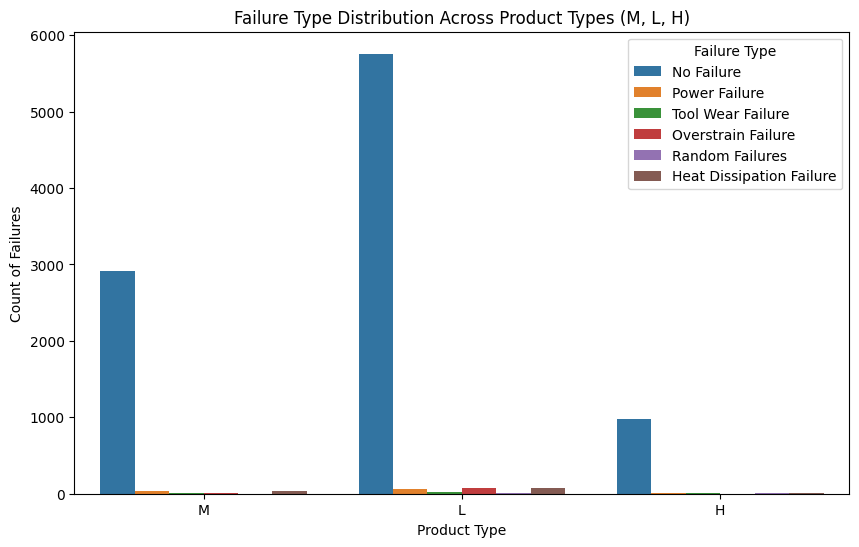

In [190]:
# Plotting a grouped bar chart for Failure Type vs Product Type
plt.figure(figsize=(10, 6))
sns.countplot(x='Type', hue='Failure Type', data=df_new)
plt.title("Failure Type Distribution Across Product Types (M, L, H)")
plt.xlabel("Product Type")
plt.ylabel("Count of Failures")
plt.xticks(rotation=0)
plt.show()


Temperature Difference Vs Torque-Speed Interaction

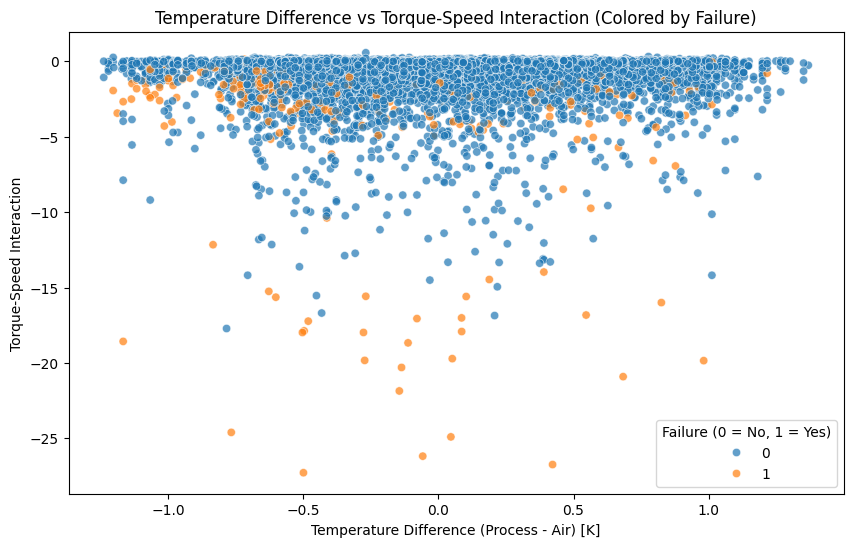

In [191]:
# Feature Engineering: Creating the temperature difference and torque-speed interaction features
df_new['temp_diff'] = df_new['Process temperature [K]'] - df_new['Air temperature [K]']
df_new['torque_speed_interaction'] = df_new['Torque [Nm]'] * df_new['Rotational speed [rpm]']

# Plotting the relationship between temperature difference and torque-speed interaction
plt.figure(figsize=(10, 6))
sns.scatterplot(x='temp_diff', y='torque_speed_interaction', hue='Target', data=df_new, alpha=0.7)
plt.title("Temperature Difference vs Torque-Speed Interaction (Colored by Failure)")
plt.xlabel("Temperature Difference (Process - Air) [K]")
plt.ylabel("Torque-Speed Interaction")
plt.legend(title="Failure (0 = No, 1 = Yes)")
plt.show()


Temperature Difference vs. Failure Occurrence

C:\Users\mnand\AppData\Local\Temp\ipykernel_11512\3359646019.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




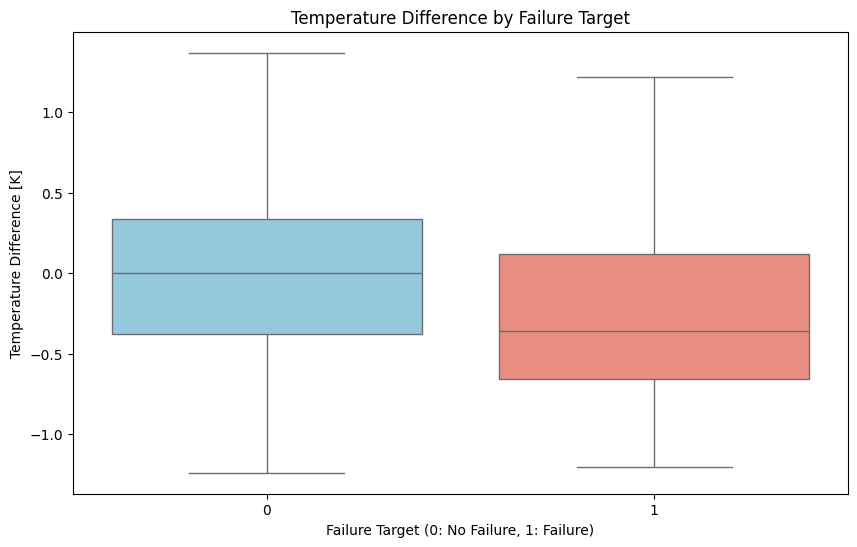

In [192]:
df_new['Temperature Difference'] = df_new['Process temperature [K]'] - df_new['Air temperature [K]']
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_new, x='Target', y='Temperature Difference', palette={'0': "skyblue", '1': "salmon"})
plt.title('Temperature Difference by Failure Target')
plt.xlabel('Failure Target (0: No Failure, 1: Failure)')
plt.ylabel('Temperature Difference [K]')
plt.show()

Torque-Speed Interaction as a Failure Predictor


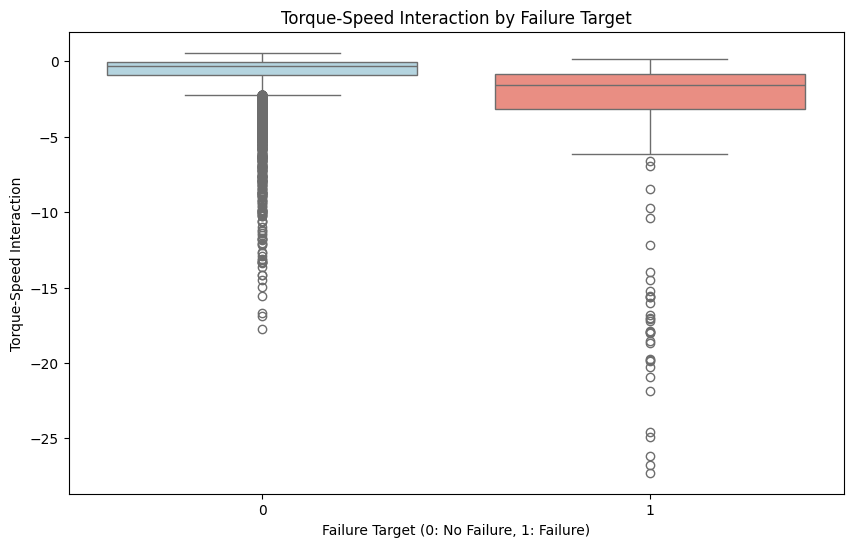

In [193]:
# Converting 'Target' column to string type for categorical handling
df_new['Target'] = df_new['Target'].astype(str)

# Plotting Torque-Speed Interaction by Failure Target with custom palette
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_new, x='Target', y='torque_speed_interaction', hue='Target', palette={"0": "lightblue", "1": "salmon"}, legend=False)
plt.title('Torque-Speed Interaction by Failure Target')
plt.xlabel('Failure Target (0: No Failure, 1: Failure)')
plt.ylabel('Torque-Speed Interaction')
plt.show()

# **Predictive Modeling**

**Random Forest Classifier**

In [194]:
# Separating features and target variable
X = df_new.drop(columns=['Target', 'Failure Type', 'UDI', 'Product ID', 'Type'])
y = df_new['Target']

In [195]:
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [196]:
# Initializing the Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)

In [197]:
# Training the classifier
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [198]:
# Making predictions on the test set
y_pred = rf_classifier.predict(X_test)

In [199]:
# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

In [200]:
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_rep)

Accuracy: 0.984
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      1939
           1       0.85      0.57      0.69        61

    accuracy                           0.98      2000
   macro avg       0.92      0.79      0.84      2000
weighted avg       0.98      0.98      0.98      2000



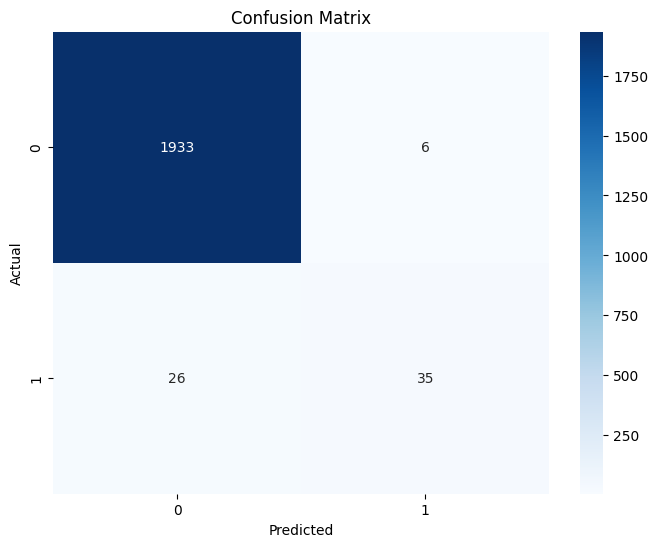

In [201]:


# Ensure y_test and y_pred have the same type
y_test = y_test.astype(str) 
# Generating the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
# Visualizing the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=rf_classifier.classes_, yticklabels=rf_classifier.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


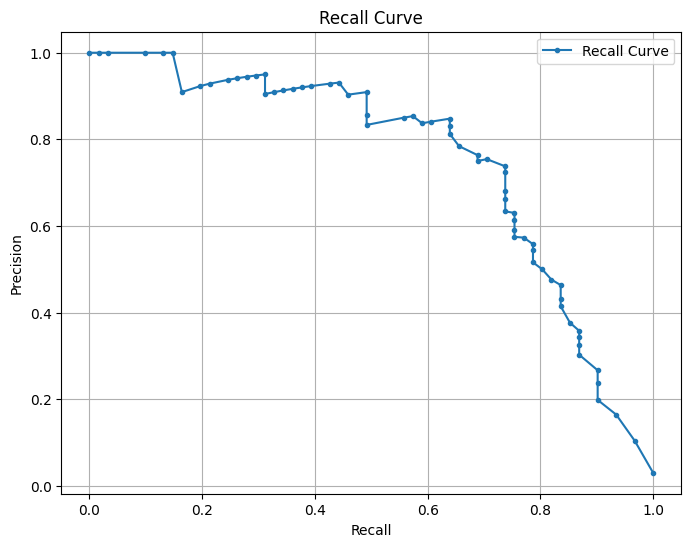

In [202]:
# Ensure y_test has integer values
y_test = y_test.astype(int)
y_scores = rf_classifier.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
# Plot the Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Recall Curve')
plt.title('Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.show()

**Logestic Regression**

In [203]:
# Separating features and target variable
X = df_new.drop(columns=['Target', 'Failure Type', 'UDI', 'Product ID', 'Type'])
y = df_new['Target']

In [204]:
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [205]:
# Initializing the Logistic Regression model
logistic_model = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')

In [206]:
# Training the Logistic Regression model
logistic_model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [207]:
# Making predictions on the test set
y_pred_logistic = logistic_model.predict(X_test)

In [208]:
# Evaluating the Logistic Regression model
accuracy_logistic = accuracy_score(y_test, y_pred_logistic)
classification_report_logistic = classification_report(y_test, y_pred_logistic)

In [209]:
print("Accuracy:", accuracy_logistic)
print("Classification Report:\n", classification_report_logistic)

Accuracy: 0.86
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.86      0.92      1939
           1       0.15      0.79      0.26        61

    accuracy                           0.86      2000
   macro avg       0.57      0.82      0.59      2000
weighted avg       0.97      0.86      0.90      2000



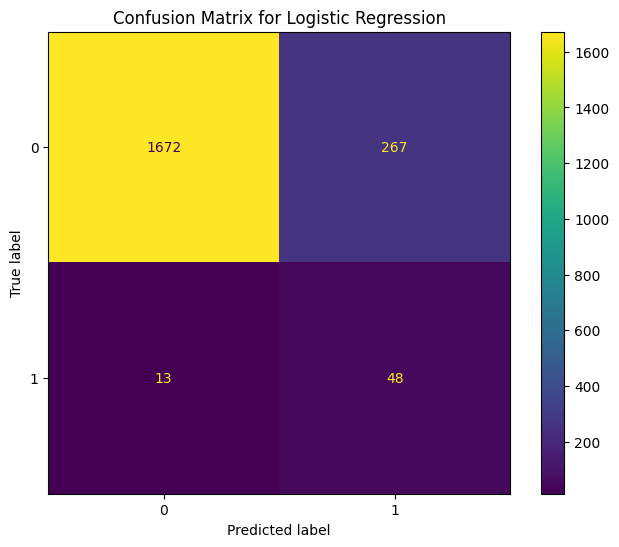

In [210]:
# Plotting the confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_estimator(logistic_model, X_test, y_test, ax=ax)
plt.title("Confusion Matrix for Logistic Regression")
plt.show()

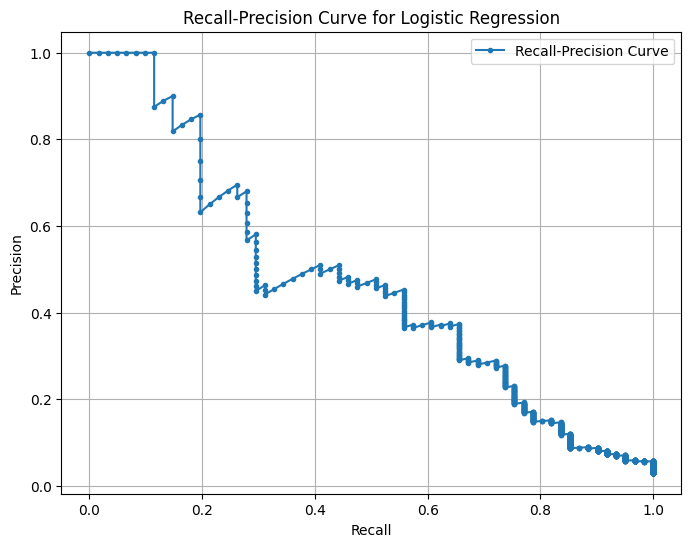

In [211]:
# Convert y_test to integers
y_test = y_test.astype(int)

# Get predicted probabilities for the positive class
y_scores = logistic_model.predict_proba(X_test)[:, 1]

# Compute precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Plot the Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Recall-Precision Curve')
plt.title('Recall-Precision Curve for Logistic Regression')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.show()

**Support Vector Machine**

In [212]:
# Separating features and target variable
X = df_new.drop(columns=['Target', 'Failure Type', 'UDI', 'Product ID', 'Type'])
y = df_new['Target']

In [213]:
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [214]:
# Initializing the Support Vector Machine classifier
svm_model = SVC(probability=True, random_state=42, class_weight='balanced')

In [215]:
# Training the SVM model
svm_model.fit(X_train, y_train)

SVC(class_weight='balanced', probability=True, random_state=42)

In [216]:
# Making predictions on the test set
y_pred_svm = svm_model.predict(X_test)

In [217]:
# Evaluating the SVM model
accuracy_svm = accuracy_score(y_test, y_pred_svm)
classification_report_svm = classification_report(y_test, y_pred_svm)

In [218]:
print("Accuracy:", accuracy_svm)
print("Classification Report:\n", classification_report_svm)

Accuracy: 0.9175
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.92      0.96      1939
           1       0.26      0.90      0.40        61

    accuracy                           0.92      2000
   macro avg       0.63      0.91      0.68      2000
weighted avg       0.97      0.92      0.94      2000



In [219]:
# Get probability estimates for the positive class
y_proba_svm = svm_model.predict_proba(X_test)[:, 1]
# Specify pos_label to handle string labels in y_test
precision, recall, _ = precision_recall_curve(y_test, y_proba_svm, pos_label='1')

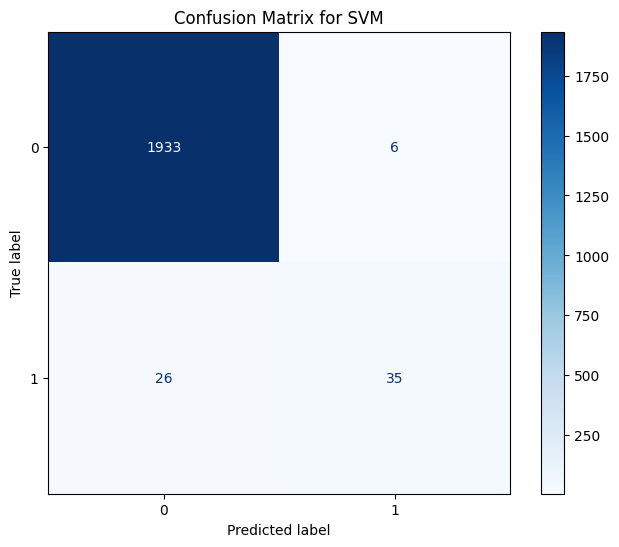

In [220]:
y_test= y_test.astype(int)  # Or str, based on your preference
y_pred = y_pred.astype(int)
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot(ax=ax, cmap="Blues")
plt.title("Confusion Matrix for SVM")
plt.show()

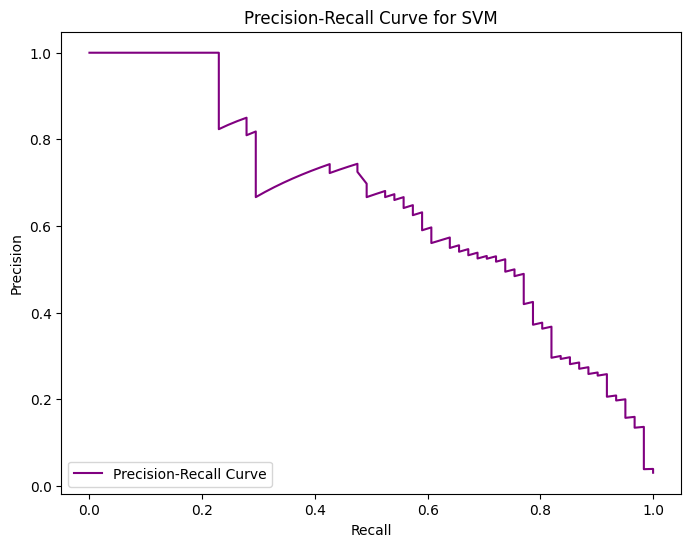

In [221]:
# Plotting the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color="purple", label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for SVM")
plt.legend(loc="lower left")
plt.show()

# **Model Optimization and Evaluation**

**Model Optimization For Random Forest Model**

In [222]:
# Define parameter grid for tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [223]:
# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

In [224]:
# Initialize GridSearchCV with cross-validation
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')

In [225]:
# Fit the model on the training data
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [226]:
# Get the best parameters from grid search
best_params = grid_search.best_params_
print("Best Parameters from Grid Search:", best_params)

Best Parameters from Grid Search: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [227]:
# Train Random Forest with the best parameters
optimized_rf = RandomForestClassifier(**best_params, random_state=42)
optimized_rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [228]:
# Make predictions
y_pred_rf = optimized_rf.predict(X_test)
y_proba_rf = optimized_rf.predict_proba(X_test)[:, 1]  # Probability of positive class
y_pred_rf = y_pred_rf.astype(int)


In [229]:
# Calculate performance metrics
accuracy_rf = accuracy_score(y_test, y_pred_rf)
classification_rep_rf = classification_report(y_test, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test, y_proba_rf)

In [230]:
print("Accuracy:", accuracy_rf)
print("Classification Report:\n", classification_rep_rf)
print("ROC AUC:", roc_auc_rf)

Accuracy: 0.984
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      1939
           1       0.85      0.57      0.69        61

    accuracy                           0.98      2000
   macro avg       0.92      0.79      0.84      2000
weighted avg       0.98      0.98      0.98      2000

ROC AUC: 0.960986312024958


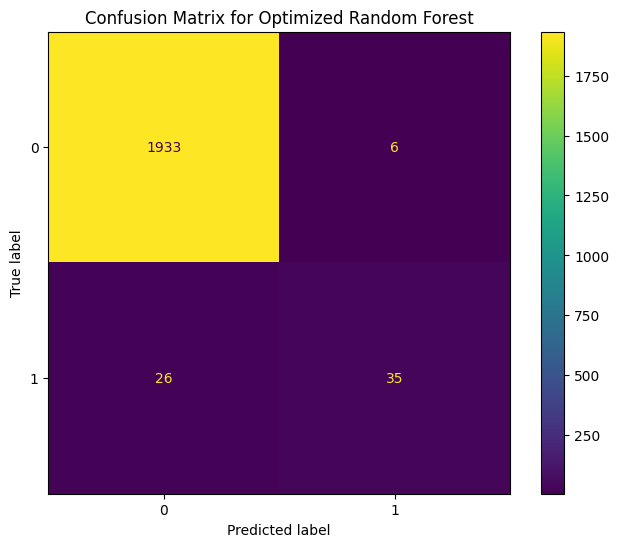

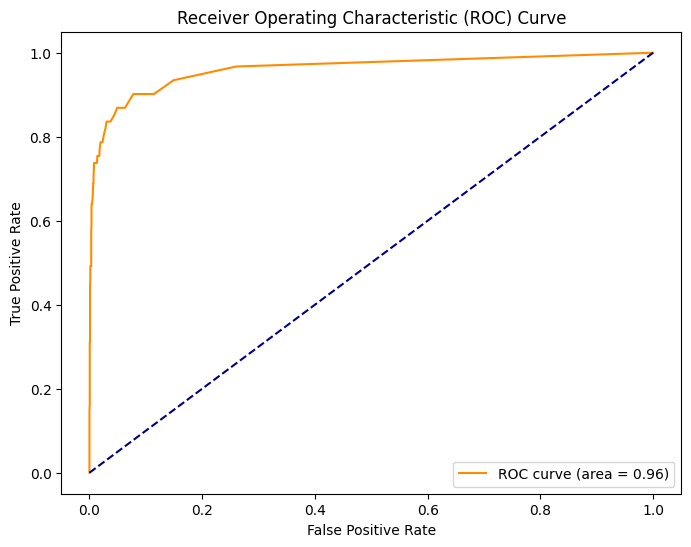

In [231]:
# Plot the confusion matrix
y_test = y_test.astype(str)
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_estimator(optimized_rf, X_test, y_test, ax=ax)
plt.title("Confusion Matrix for Optimized Random Forest")
plt.show()

# Plot the ROC curve
fpr, tpr, _ = roc_curve(y_test.astype(int), y_proba_rf)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="darkorange", label=f"ROC curve (area = {roc_auc_rf:.2f})")
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

**Model Optimization For Logistic Regression**

In [232]:
# parameter grid for Logistic Regression
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'], 
    'solver': ['liblinear', 'saga'], 
}

In [233]:
# Initialize the Logistic Regression model
logistic_model = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')

In [234]:
# Initialize GridSearchCV with cross-validation
grid_search_logistic = GridSearchCV(estimator=logistic_model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')

In [235]:
# Grid search with the parameter grid
grid_search_logistic = GridSearchCV(
    estimator=logistic_model,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring='accuracy',
    error_score='raise',  
)

In [236]:
# Fit the model
grid_search_logistic.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=1000, random_state=42),
             n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             scoring='accuracy')

In [237]:
# Get the best parameters
best_params_logistic = grid_search_logistic.best_params_
print("Best Parameters:", best_params_logistic)

Best Parameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'saga'}


In [238]:
# Train Logistic Regression with the best parameters
optimized_logistic = LogisticRegression(**best_params_logistic, max_iter=1000, random_state=42)
optimized_logistic.fit(X_train, y_train)


LogisticRegression(C=0.01, max_iter=1000, random_state=42, solver='saga')

In [239]:
# Make predictions
y_pred_logistic = optimized_logistic.predict(X_test)
y_proba_logistic = optimized_logistic.predict_proba(X_test)[:, 1] 

In [240]:
# Calculate performance metrics
accuracy_logistic = accuracy_score(y_test, y_pred_logistic)
classification_rep_logistic = classification_report(y_test, y_pred_logistic)
roc_auc_logistic = roc_auc_score(y_test, y_proba_logistic)

In [241]:

print("Accuracy:", accuracy_logistic)
print("Classification Report:\n", classification_rep_logistic)
print("ROC AUC:", roc_auc_logistic)

Accuracy: 0.9735
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      1939
           1       0.75      0.20      0.31        61

    accuracy                           0.97      2000
   macro avg       0.86      0.60      0.65      2000
weighted avg       0.97      0.97      0.97      2000

ROC AUC: 0.9105673872792296


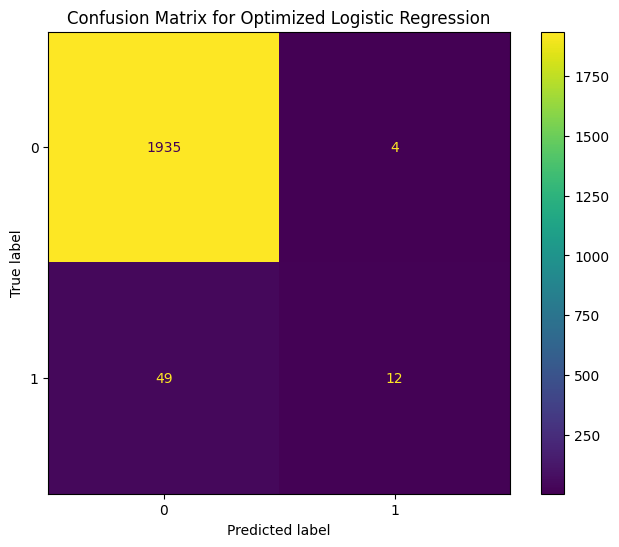

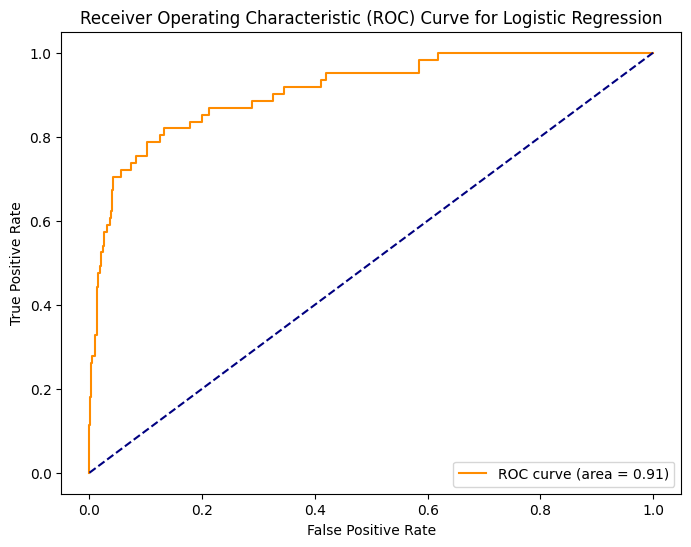

In [242]:
# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_estimator(optimized_logistic, X_test, y_test, ax=ax)
plt.title("Confusion Matrix for Optimized Logistic Regression")
plt.show()

y_test = y_test.astype(int)


# Plot the ROC curve
fpr_logistic, tpr_logistic, _ = roc_curve(y_test, y_proba_logistic)
plt.figure(figsize=(8, 6))
plt.plot(fpr_logistic, tpr_logistic, color="darkorange", label=f"ROC curve (area = {roc_auc_logistic:.2f})")
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve for Logistic Regression")
plt.legend(loc="lower right")
plt.show()


# **Insights and Recommendations**

**Insight Generation**

In [243]:
feature_importance = pd.DataFrame({
    'Feature': X.columns, 
    'Importance': rf_classifier.feature_importances_
}).sort_values(by='Importance', ascending=False)

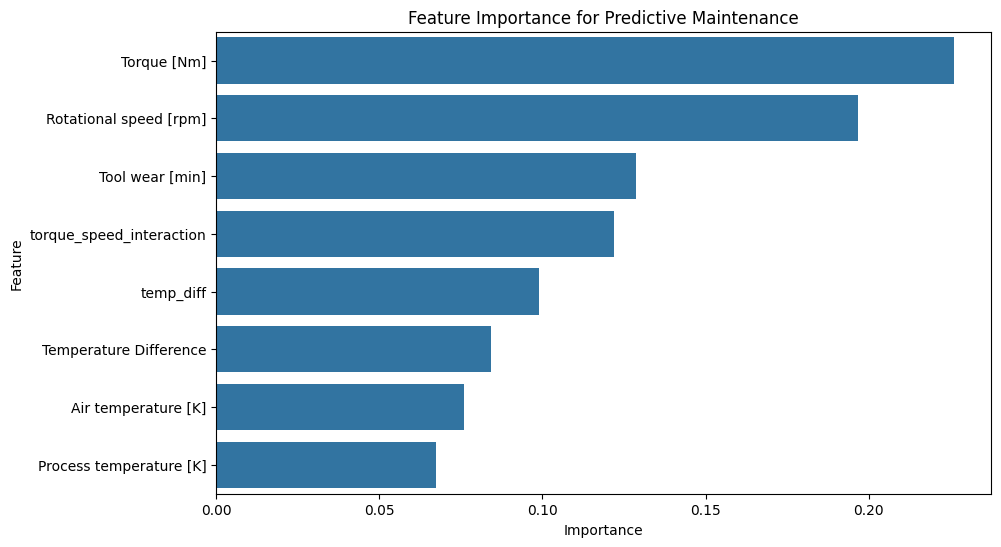

In [244]:
# Plot the feature importance
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='Importance', y='Feature')
plt.title('Feature Importance for Predictive Maintenance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [245]:
def scaled_early_warning_system(row):
    """
    Detect potential equipment failure using scaled thresholds.
    """
    if row['temp_diff'] > df_new['temp_diff'].mean() + df_new['temp_diff'].std() or \
       row['Rotational speed [rpm]'] > df_new['Rotational speed [rpm]'].mean() + df_new['Rotational speed [rpm]'].std() or \
       row['Torque [Nm]'] > df_new['Torque [Nm]'].mean() + df_new['Torque [Nm]'].std() or \
       row['Tool wear [min]'] > df_new['Tool wear [min]'].mean() + df_new['Tool wear [min]'].std():
        return "Warning"
    return "Safe"


In [246]:
# Apply the system
df_new['Status'] = df_new.apply(scaled_early_warning_system, axis=1)

In [247]:
# Ensure the Status column is correctly computed
if 'Status' not in df_new.columns:
    print("Error: 'Status' column not found. Reapplying early warning system.")
    df_new['Status'] = df_new.apply(early_warning_system, axis=1)

# Print the distribution
print("Warning Distribution:")
print(df_new['Status'].value_counts())


Warning Distribution:
Status
Warning    5272
Safe       4728
Name: count, dtype: int64


C:\Users\mnand\AppData\Local\Temp\ipykernel_11512\2427383727.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




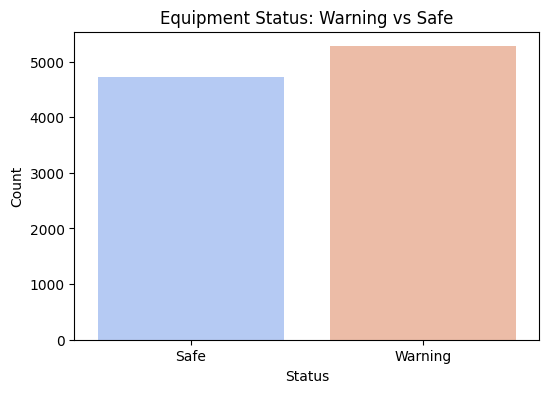

In [248]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df_new, x='Status', palette='coolwarm')
plt.title('Equipment Status: Warning vs Safe')
plt.xlabel('Status')
plt.ylabel('Count')
plt.show()

In [249]:
# Define the output directory
output_dir = r"D:\DataScience Project Final\Outputs"

# Create the directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Now save the file
df_new.to_csv(os.path.join(output_dir, 'predictive_maintenance_with_warnings.csv'), index=False)
print(f"Updated dataset with warnings saved at '{output_dir}'")


Updated dataset with warnings saved at 'D:\DataScience Project Final\Outputs'


**Maintenance Strategies**

In [250]:
def adaptive_maintenance_schedule(row):
    # Calculate dynamic thresholds based on the dataset
    tool_wear_threshold = df_new['Tool wear [min]'].quantile(0.90)
    temp_diff_threshold = df_new['temp_diff'].quantile(0.90)
    
    # Apply dynamic risk categorization
    if row['Status'] == 'Warning':
        return 'Critical Risk: Immediate Action'
    if row['Tool wear [min]'] > tool_wear_threshold or row['temp_diff'] > temp_diff_threshold:
        return 'Moderate Risk: Schedule Maintenance'
    return 'Low Risk: Routine Inspection'


In [251]:
# Apply the dynamic maintenance schedule
df_new['Maintenance Strategy'] = df_new.apply(adaptive_maintenance_schedule, axis=1)

In [252]:
# View Maintenance Strategies
print(df_new['Maintenance Strategy'].value_counts())

Maintenance Strategy
Critical Risk: Immediate Action    5272
Low Risk: Routine Inspection       4728
Name: count, dtype: int64


In [253]:
# Save the Maintenance Schedule for Implementation
df_new.to_csv('D:\DataScience Project Final\Outputs\predictive_maintenance_schedule.csv', index=False)
print("Maintenance schedule saved as 'D:\DataScience Project Final\outputs\predictive_maintenance_schedule.csv'.")

Maintenance schedule saved as 'D:\DataScience Project Final\outputs\predictive_maintenance_schedule.csv'.


<>:2: SyntaxWarning:

invalid escape sequence '\D'

<>:3: SyntaxWarning:

invalid escape sequence '\D'

<>:2: SyntaxWarning:

invalid escape sequence '\D'

<>:3: SyntaxWarning:

invalid escape sequence '\D'

C:\Users\mnand\AppData\Local\Temp\ipykernel_11512\1063720856.py:2: SyntaxWarning:

invalid escape sequence '\D'

C:\Users\mnand\AppData\Local\Temp\ipykernel_11512\1063720856.py:3: SyntaxWarning:

invalid escape sequence '\D'



In [254]:
# Prepare Data for Dashboard
status_counts = df_new['Maintenance Strategy'].value_counts()
status_fig = px.bar(status_counts, x=status_counts.index, y=status_counts.values, title='Maintenance Strategy Distribution')

In [255]:
# Create Dash App
app = dash.Dash(__name__)

app.layout = html.Div([
    html.H1("Predictive Maintenance Dashboard"),
    dcc.Graph(figure=status_fig)
])

if __name__ == '__main__':
    app.run_server(debug=True)